In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from cycler import cycler
#umPerPix = 1000/float(siHeader['metadata']['hRoiManager']['scanZoomFactor'])/int(siHeader['metadata']['hRoiManager']['pixelsPerLine'])
umPerPix = 1.7755681818181817
plt.rcParams.update({
    'figure.figsize': (1, 1),        # Small figure
    'font.size': 4,                  # Small text
    'axes.titlesize': 6,
    'axes.labelsize': 6,
    'xtick.labelsize': 5,
    'ytick.labelsize': 5,
    'legend.fontsize': 5,
    'figure.dpi': 300,
    'lines.linewidth': 0.5,          # Thin lines
    'lines.color': 'k',              # Line color (note: overridden by prop_cycle)
    'axes.prop_cycle': cycler('color', ['k']),  # Use black for all plot elements
    'scatter.marker': '.',           # Dot marker
    'lines.markersize': 2,            # Small dots if used
    'lines.linewidth': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth' : 0.2,
    'xtick.major.width': 0.3,
    'ytick.major.width': 0.3,
    'xtick.minor.width': 0.3,
    'ytick.minor.width': 0.3,
})


def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

def stim_amp_nwb(dff, photostim, pre_frames=5, post_frames=4, response_start=16, response_end=20):
    stim_frames = photostim[photostim.stim_name == "photostim"].start_frame.values
    n_rois = dff.shape[1]
    valid_trials = []

    for frame in stim_frames:
        if frame - pre_frames < 0 or frame + response_end >= dff.shape[0]:
            continue
        valid_trials.append(frame)

    favg = np.zeros((response_end, n_rois, len(valid_trials)))

    for i, frame in enumerate(valid_trials):
        trial_window = dff[frame : frame + response_end, :]  # shape: (frames, rois)
        baseline = np.nanmean(dff[frame + pre_frames : frame + post_frames, :], axis=0)
        norm = (trial_window - baseline) / baseline
        favg[:, :, i] = norm

    amp = np.nanmean(favg[response_start:response_end, :, :], axis=0) - np.nanmean(favg[pre_frames:post_frames, :, :], axis=0)

    return amp, favg

def compute_groupwise_stim_distance(centroidX, centroidY, photostim):
    """
    Compute stimDist: distance from each neuron to each unique stimulation group.
    
    Returns:
    --------
    stimDist_group : array of shape (n_neurons, n_groups)
    """
    roi_coords = np.stack((centroidX, centroidY), axis=1)  # shape (n_neurons, 2)

    # Group photostim trials by group_index and compute group centroid
    group_table = photostim[photostim.stim_name == 'photostim']
    groups = group_table.groupby('group_index')[['laser_stim_x', 'laser_stim_y']].mean()
    stim_coords = groups.values  # shape (n_groups, 2)

    n_rois = roi_coords.shape[0]
    n_groups = stim_coords.shape[0]

    stimDist_group = np.zeros((n_rois, n_groups))
    for g in range(n_groups):
        dx = roi_coords[:, 0] - stim_coords[g, 0]
        dy = roi_coords[:, 1] - stim_coords[g, 1]
        stimDist_group[:, g] = np.sqrt(dx**2 + dy**2)

    return stimDist_group
# Step 1: Get ROI centroids
centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

# Step 2: Compute stimDist (neuron x group)
stimDist = compute_groupwise_stim_distance(centroidX, centroidY, photostim)
stimDist = stimDist * umPerPix


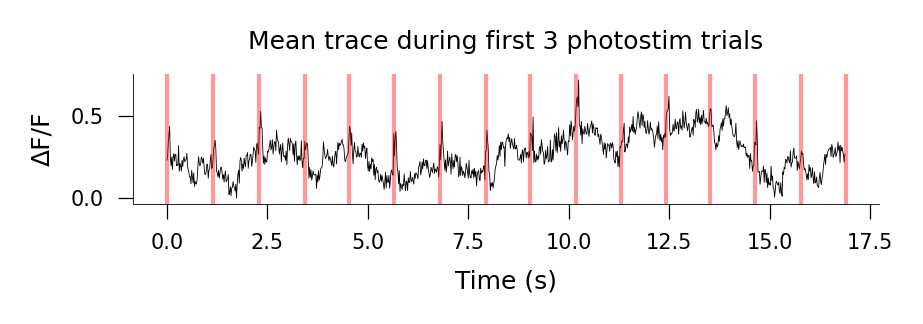

In [21]:
# Get first 3 photostim events
events = photostim[photostim.stim_name == 'photostim'].iloc[:16]
stim_frames = events['start_frame'].values
cells = [np.argmin(stimDist[g,:]) for g in events['group_index']]

# Define time window: 2s before first stim to 3s after last
start_f = max(0, stim_frames[0] - int(.2 * frame_rate))
stop_f  = min(len(dff), stim_frames[-1] + int(0 * frame_rate))
t = np.arange(start_f, stop_f) / frame_rate

# Plot average trace during this window
plt.figure(figsize=(3, 1))
trace = np.nanmean(dff[start_f:stop_f], axis=1)
plt.plot(t, trace, 'k', linewidth=0.2)

# Overlay stim event markers
for f in stim_frames:
    if start_f <= f <= stop_f:
        plt.axvline(f / frame_rate, color='r', linestyle='-', alpha=0.4,linewidth=1)

plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title('Mean trace during first 3 photostim trials')
plt.tight_layout()
plt.show()


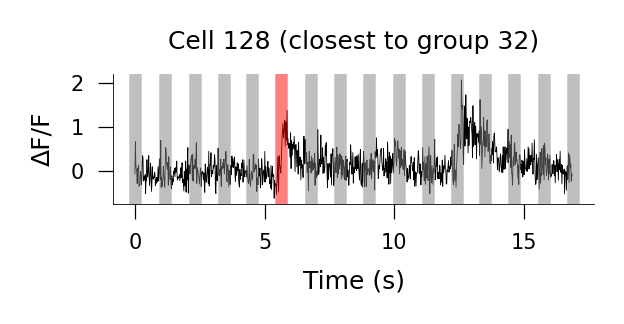

In [22]:
trial_of_interest = 5


# Compute ROI coordinates
centroids = get_roi_centroids(image_segmentation)  # returns (n_rois, 2)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]
roi_coords = np.stack((centroidX, centroidY), axis=1)  # (n_neurons, 2)

# Get early events
events = photostim[photostim.stim_name == 'photostim'].iloc[:16]
stim_frames = events['start_frame'].values
groups = events['group_index'].values

# Compute group coordinates (mean x/y per group)
group_means = photostim[photostim.stim_name == 'photostim'] \
    .groupby('group_index')[['laser_stim_x', 'laser_stim_y']].mean()

# Align group order to those used in this block
stim_coords = group_means.loc[groups].values  # shape: (n_groups, 2)

# Compute stimDist manually
stimDist = np.linalg.norm(roi_coords[:, None, :] - stim_coords[None, :, :], axis=2)  # (n_rois, n_groups)

# Trial of interest
group = groups[trial_of_interest] - 1  # MATLAB to Python indexing
cell = np.argmin(stimDist[:, trial_of_interest])  # closest to that group's stim coords

# Time window
start_f = max(0, stim_frames[0] - int(0.2 * frame_rate))
stop_f  = min(len(dff), stim_frames[-1] + int(0 * frame_rate))
t = np.arange(start_f, stop_f) / frame_rate

# Plot
plt.figure(figsize=(2, 1))
trace = dff[start_f:stop_f, cell]
plt.plot(t, trace, 'k', linewidth=0.2)

for i, f in enumerate(stim_frames):
    if start_f <= f <= stop_f:
        color = 'gray'
        if i == trial_of_interest:
            color = 'r'
        plt.axvline(f / frame_rate, color=color, linestyle='-', alpha=0.5, linewidth=3)

plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title(f'Cell {cell} (closest to group {group})')
plt.tight_layout()
plt.show()


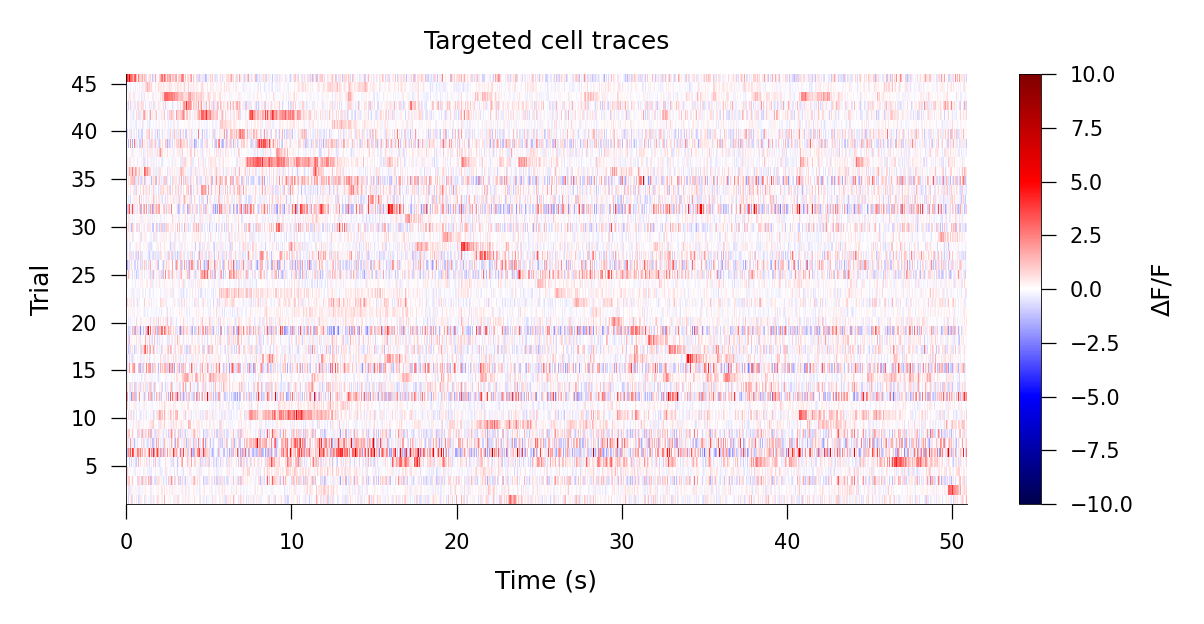

In [23]:
# Define time window: from 0.2s before first stim to 0s after last stim
pre_f = int(0.2 * frame_rate)
post_f = 0  # if you want to extend this, set to int(n seconds * frame_rate)

# Extract events
events = photostim[photostim.stim_name == 'photostim'].iloc[:46]
stim_frames = events['start_frame'].values
groups = events['group_index'].values

# ROI coordinates
centroids = get_roi_centroids(image_segmentation)
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)

# Group stim coordinates
group_means = photostim[photostim.stim_name == 'photostim'] \
    .groupby('group_index')[['laser_stim_x', 'laser_stim_y']].mean()
stim_coords = group_means.loc[groups].values

# Compute stimDist
stimDist = np.linalg.norm(roi_coords[:, None, :] - stim_coords[None, :, :], axis=2)

# Determine which cell was targeted on each trial
target_cells = [np.argmin(stimDist[:, i]) for i in range(len(groups))]

# Shared time window (absolute time)
start_f = max(0, stim_frames[0] - pre_f)
stop_f = min(len(dff), stim_frames[-1] + post_f)
t = np.arange(start_f, stop_f) / frame_rate

# Extract traces for each targeted cell over this window
traces = np.array([dff[start_f:stop_f, cell] for cell in target_cells])

# Plot heatmap
plt.figure(figsize=(4, 2))
plt.imshow(traces, aspect='auto', cmap='seismic', vmin=-10, vmax=10,
           extent=[t[0], t[-1], 1, len(traces)],interpolation = 'none')
plt.xlabel('Time (s)')
plt.ylabel('Trial')
plt.title('Targeted cell traces')
plt.colorbar(label='ΔF/F')
plt.tight_layout()
plt.show()


In [24]:
# Pick a photostim group
gi = 6

# Find the closest cell
cell = np.argmin(stimDist[:, gi])

# Plot all trials for that group
trials = np.where(seq == gi)[0]
plt.plot(Fstim[:, cell, trials], 'k', alpha=0.3)
plt.plot(np.nanmean(Fstim[:, cell, trials], axis=1), 'r')
plt.axvline(pre_frames, color='gray', linestyle='--')
plt.title(f'Cell {cell} (closest to stim group {gi})')
plt.xlabel('Frame')
plt.ylabel('ΔF/F')
plt.tight_layout()
plt.show()


NameError: name 'seq' is not defined

In [64]:
pre_frames = 30
post_frames = 30
window_size = pre_frames + post_frames

stim_frames = photostim[photostim.stim_name == "photostim"]['start_frame'].values
dff = np.array(dff)  # ensure numpy
# Preallocate: (time, neuron, trial)
n_trials = len(stim_frames)
n_neurons = dff.shape[1]
Fstim = np.full((window_size, n_neurons, n_trials), np.nan)

for k, frame in enumerate(stim_frames):
    if frame - pre_frames < 0 or frame + post_frames >= dff.shape[0]:
        continue
    Fstim[:, :, k] = dff[frame - pre_frames : frame + post_frames, :]
print(Fstim.shape)


seq = photostim[photostim.stim_name == 'photostim']['group_index'].values
seq = seq - 1  # convert MATLAB-style to Python-style
numGroups = np.max(seq) + 1

favg = np.zeros((Fstim.shape[0], Fstim.shape[1], numGroups))
for gi in range(numGroups):
    ind = np.where(seq == gi)[0]
    favg[:, :, gi] = np.nanmean(Fstim[:, :, ind], axis=2)


favg_raw = favg.copy()


(60, 385, 1047)


(-0.05, 0.25)

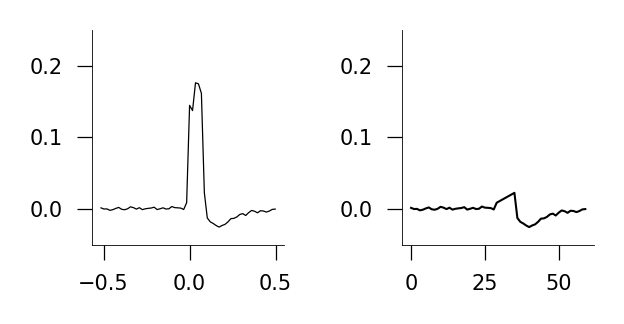

In [57]:
#Remove the photostim artifact
# Time vector centered at stim (0 s)
times = photostim['start_time'].values
frames = photostim['start_frame'].values
dt_si = (times[2]-times[1]) / (frames[1]-frames[0])
n_timepoints = favg.shape[0]
center_idx = int((pre_frames + post_frames) / 2)
tvec = (np.arange(n_timepoints) - center_idx) * dt_si
fig = plt.figure(figsize=(2,1))  


after = np.floor(0.2/dt_si)
before = np.floor(0.2/dt_si)
artifact = np.nanmean(np.nanmean(favg_raw,axis=2),axis=1)
artifact = artifact - np.nanmean(artifact[0:4])
plt.subplot(121)
plt.plot(tvec,artifact)
plt.ylim((-.05,.25))

artifact = np.where(artifact > .1)[0]
artifact = artifact[artifact<40]
pre = (int(artifact[0]-before),int(artifact[0]-2))
post = (int(artifact[-1]+2),int(artifact[-1]+after))
favg[artifact, :, :] = np.nan

# Interpolate NaNs over time (axis=0) for each (roi, group) pair
for roi in range(favg.shape[1]):
    for group in range(favg.shape[2]):
        trace = favg[:, roi, group]
        if np.any(np.isnan(trace)):
            good = np.where(~np.isnan(trace))[0]
            if good.size > 1:
                favg[:, roi, group] = np.interp(
                    np.arange(len(trace)),
                    good,
                    trace[good]
                )


f = np.nanmean(np.nanmean(favg,axis=2),axis=1)
f = f - np.nanmean(f[0:4])
plt.subplot(122)
plt.plot(f,'k',linewidth=.5)
plt.tight_layout()
plt.ylim((-.05,.25))

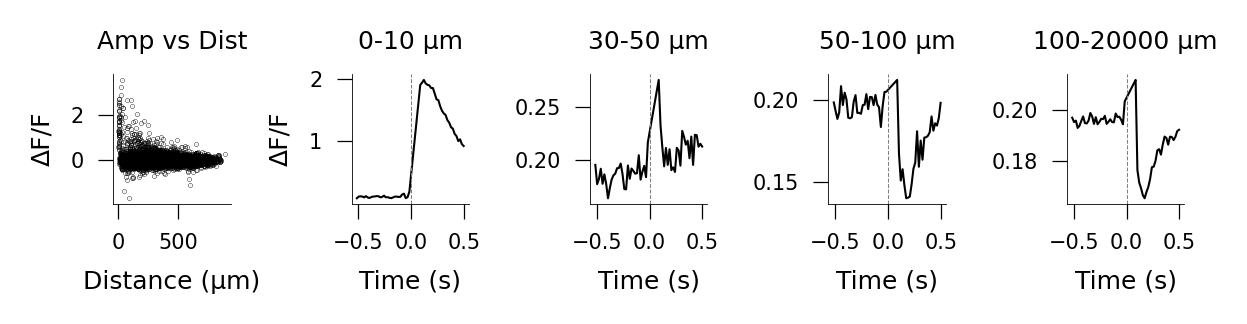

In [58]:
#summarize spatial structure of photostimulation 

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(4, 1))
stimDist = compute_groupwise_stim_distance(centroidX, centroidY, photostim)
stimDist = stimDist * umPerPix
# Compute amplitude map
amp = np.nanmean(favg[post_frames:post_frames + 10, :, :], axis=0) - np.nanmean(favg[pre_frames - 10:pre_frames, :, :], axis=0)

# Plot amplitude vs distance
plt.subplot(1, 5, 1)
plt.plot(stimDist.flatten(), amp.flatten(), 'k.', markersize=0.2)
plt.xlabel('Distance (μm)')
plt.ylabel('ΔF/F')
plt.title('Amp vs Dist')

# Define bins
bins = [(0, 10), (30, 50), (50, 100),(100,20000)]


# Plot mean responses for each distance bin
for bi, (low, high) in enumerate(bins):
    f = []
    for gi in range(favg.shape[2]):
        x = stimDist[:, gi]
        ind = np.where((x < high) & (x > low))[0]
        if len(ind) > 0:
            f.append(np.nanmean(favg[:, ind, gi], axis=1))
    if len(f) == 0:
        continue
    f = np.stack(f, axis=1)
    
    plt.subplot(1, 5, bi + 2)
    plt.plot(tvec, np.nanmean(f, axis=1), 'k', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.25)
    plt.title(f"{low}-{high} μm")
    if bi == 0:
        plt.ylabel('ΔF/F')
    plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()


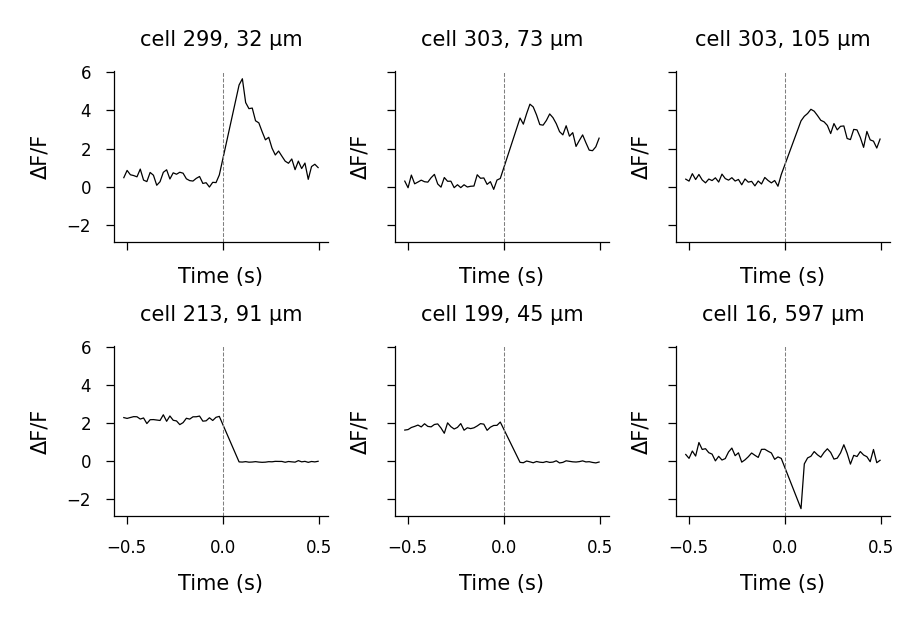

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Identify all (neuron, group) pairs more than 30 um from a stim target
mask = stimDist > 30

amp_flat = amp[mask]
neuron_idx, group_idx = np.where(mask)

# Sort by response amplitude
sorted_exc = np.argsort(-amp_flat)  # descending
sorted_inh = np.argsort(amp_flat)   # ascending

# Select top 3
exc_pairs = list(zip(neuron_idx[sorted_exc[:3]], group_idx[sorted_exc[:3]]))
inh_pairs = list(zip(neuron_idx[sorted_inh[:3]], group_idx[sorted_inh[:3]]))

# Plot setup
fig, axs = plt.subplots(2, 3, figsize=(3, 2), sharex=True, sharey=True)

# Plot excited cells (top row)
for i, (cid, gid) in enumerate(exc_pairs):
    ax = axs[0, i]
    trace = favg[:, cid, gid]
    dist = stimDist[cid, gid]
    ax.plot(tvec, trace, 'k', linewidth=0.3)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.25)
    ax.set_title(f"cell {cid}, {dist:.0f} µm", fontsize=5)

# Plot inhibited cells (bottom row)
for i, (cid, gid) in enumerate(inh_pairs):
    ax = axs[1, i]
    trace = favg[:, cid, gid]
    dist = stimDist[cid, gid]
    ax.plot(tvec, trace, 'k', linewidth=0.3)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.25)
    ax.set_title(f"cell {cid}, {dist:.0f} µm", fontsize=5)

# Formatting
for ax in axs.flat:
    ax.set_xlabel('Time (s)', fontsize=5)
    ax.set_ylabel('ΔF/F', fontsize=5)
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(width=0.3, length=2, labelsize=4)
    for spine in ax.spines.values():
        spine.set_linewidth(0.3)

plt.tight_layout()
plt.show()
